# Packages and variables

In [6]:
!pip install datasets
!pip install transformers
!pip install tqdm

  Using cached datasets-2.12.0-py3-none-any.whl (474 kB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
     -------------------------------------- 319.8/319.8 kB 4.0 MB/s eta 0:00:00
     --------------------------------------- 21.5/21.5 MB 13.4 MB/s eta 0:00:00
     -------------------------------------- 134.3/134.3 kB 8.3 MB/s eta 0:00:00
     ---------------------------------------- 61.0/61.0 kB ? eta 0:00:00
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1


In [8]:
# Load packages
from sentence_transformers import models, losses, datasets, SentencesDataset
from sentence_transformers import SentenceTransformer, util, InputExample
import pandas as pd
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.manifold import MDS

In [9]:
# Specify variables
model_name = "bert-base-uncased"
train_batch_size = 20
max_seq_length = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load and prepare dataset

In [12]:
# Load dataset from huggingface
dataset = load_dataset("multi_nli")

# and make dataset as dataframe for easier usage
df = pd.DataFrame()
df["premise"] = dataset["train"]["premise"]
df["hypothesis"] = dataset["train"]["hypothesis"]
df["genre"] = dataset["train"]["genre"]
df["label"] = dataset["train"]["label"]

df_test = pd.DataFrame()
df_test["premise"] = dataset["validation_matched"]["premise"]
df_test["hypothesis"] = dataset["validation_matched"]["hypothesis"]
df_test["genre"] = dataset["validation_matched"]["genre"]
df_test["label"] = dataset["validation_matched"]["label"]

Found cached dataset multi_nli (C:/Users/nisha/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

# Test Triplet

In [8]:
# load triplet model
model = SentenceTransformer("bert-base-nli-mean-tokens")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print("Processing genre:", genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

Processing genre: telephone
Processing genre: government
Processing genre: travel
Processing genre: fiction
Processing genre: slate


9815it [45:28,  3.60it/s]

{'slate': 0.6670460061513597, 'government': 0.6823839737847694, 'telephone': 0.6847856419715158, 'travel': 0.6789847530642228, 'fiction': 0.6795106948289112}


# Visualize Triplet

In [9]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

C:\Users\nisha\anaconda3\envs\sevila\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


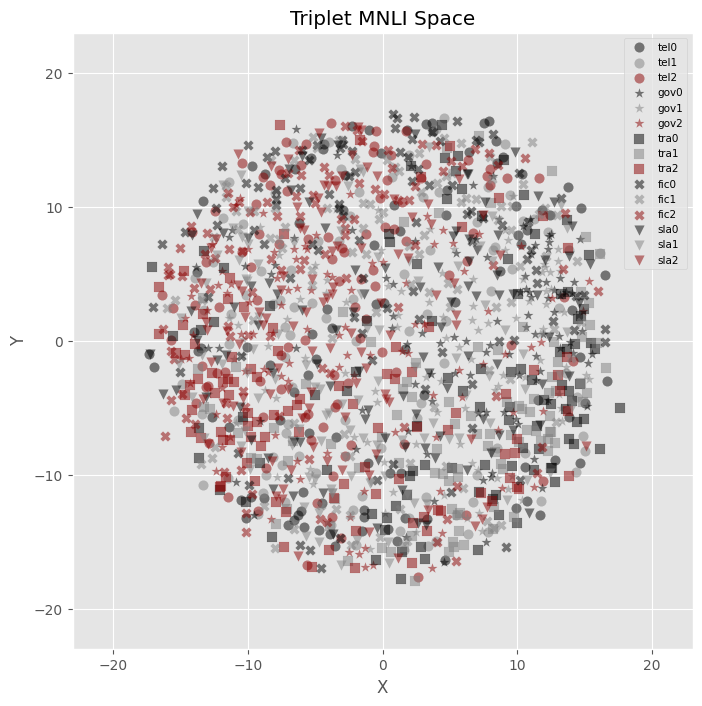

In [10]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("Triplet MNLI Space")

plt.show()

# Test Adacos

In [12]:
from metrics import AdaCos

In [30]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from tqdm import tqdm

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
model = AutoModel.from_pretrained("roberta-large-mnli")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,1024), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(1024)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            encoded_dict = tokenizer(row["premise"], row["hypothesis"], padding=True, truncation=True, max_length=128, return_tensors='pt')
            with torch.no_grad():
                outputs = model(**encoded_dict)
                emb = outputs.last_hidden_state.mean(dim=1).squeeze()
            mean_embedding = np.concatenate((mean_embedding, emb.cpu().numpy()))
            all_data = np.concatenate((all_data, emb.cpu().numpy().reshape(-1,1024)), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n

# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    encoded_dict = tokenizer(row["premise"], row["hypothesis"], return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded_dict)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze()
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 1024), clusters[genre + str(0)].reshape(-1, 1024))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 1024), clusters[genre + str(2)].reshape(-1, 1024))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]

print(error)


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


telephone
government
travel
fiction
slate


9815it [2:44:02,  1.00s/it]

{'slate': 0.6670076726342711, 'government': 0.6915167095115681, 'telephone': 0.685147507629705, 'travel': 0.6842105263157895, 'fiction': 0.6811961479979727}


In [15]:
# load triplet model
model = SentenceTransformer("model_adacos_mnli", device="cuda")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-6460e8d8-0f979caa3198a26c5d4a40dc)

Repository Not Found for url: https://huggingface.co/api/models/sentence-transformers/model_adacos_mnli.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.
Invalid username or password.

# Visualize AdaCos

In [33]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

C:\Users\nisha\anaconda3\envs\sevila\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


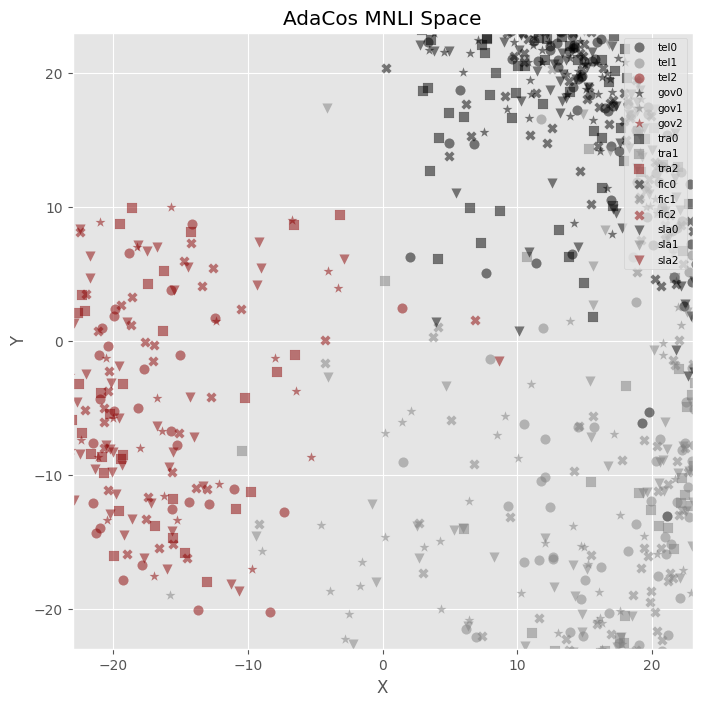

In [35]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("AdaCos MNLI Space")

plt.show()

# Test Adacos + Pairwise

In [10]:
# load triplet model
model = SentenceTransformer("model_pairwise_mnli", device="cuda")

# find average embeddings of positive and negative clusters from a sample (100) of training data
# we use a very small sample here as later the mds algorithm is quite slow even with few data
# but 100 data samples is still enough to find the cluster centers
clusters = {}
# saving data for visualization too
all_data = np.empty((0,768), float)
labs = []
genres = []

for genre in ["telephone","government","travel","fiction","slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"]==genre) & (df["label"]==label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
            mean_embedding += emb
            all_data = np.append(all_data, emb.reshape(-1,768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding/n
        
# get error as average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    emb = model.encode(row["premise"] + " " + tokenizer.sep_token + " " + row["hypothesis"])
    if genre not in error:
        error[genre] = 0
        n[genre] = 0
    
    # get cosine similarity with positive and negative clusters for the genre
    # when testing should be done with each class to get prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi-nega)/2)
    n[genre] += 1

for genre in ["telephone","government","travel","fiction","slate"]:        
    error[genre] /= n[genre]
    
print(error)

RepositoryNotFoundError: 401 Client Error. (Request ID: Root=1-6461cd5e-528f2fe64af42ab31754670c)

Repository Not Found for url: https://huggingface.co/api/models/sentence-transformers/model_pairwise_mnli.
Please make sure you specified the correct `repo_id` and `repo_type`.
If the repo is private, make sure you are authenticated.
Invalid username or password.

In [13]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Find average embeddings of positive and negative clusters from a sample (100) of training data
# We use a very small sample here as later the MDS algorithm is quite slow even with few data
# But 100 data samples are still enough to find the cluster centers
clusters = {}
# Saving data for visualization too
all_data = np.empty((0, 768), float)
labs = []
genres = []

for genre in ["telephone", "government", "travel", "fiction", "slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"] == genre) & (df["label"] == label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            inputs = tokenizer.encode_plus(row["premise"], row["hypothesis"], add_special_tokens=True, return_tensors='pt')
            input_ids = inputs['input_ids'].to(model.device)
            attention_mask = inputs['attention_mask'].to(model.device)

            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)

            embeddings = outputs.last_hidden_state[:, 0, :]
            mean_embedding += embeddings.cpu().numpy()
            all_data = np.append(all_data, embeddings.cpu().numpy(), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding / n

# Get error as the average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    inputs = tokenizer.encode_plus(row["premise"], row["hypothesis"], add_special_tokens=True, return_tensors='pt')
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    if genre not in error:
        error[genre] = 0
        n[genre] = 0

    # Get cosine similarity with positive and negative clusters for the genre
    # When testing, it should be done with each class to get the prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi - nega) / 2)
    n[genre] += 1

for genre in ["telephone", "government", "travel", "fiction", "slate"]:
    error[genre] /= n[genre]

print(error)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


telephone


ValueError: non-broadcastable output operand with shape (768,) doesn't match the broadcast shape (1,768)

In [19]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Find average embeddings of positive and negative clusters from a sample (100) of training data
# We use a very small sample here as later the MDS algorithm is quite slow even with few data
# But 100 data samples are still enough to find the cluster centers
clusters = {}
# Saving data for visualization too
all_data = np.empty((0, 768), float)
labs = []
genres = []

for genre in ["telephone", "government", "travel", "fiction", "slate"]:
    print(genre)
    for label in range(3):
        n = 0
        mean_embedding = np.zeros(768)
        tmp_dataset = df[(df["genre"] == genre) & (df["label"] == label)].sample(100)

        for _, row in tmp_dataset.iterrows():
            inputs = tokenizer.encode_plus(row["premise"], row["hypothesis"], add_special_tokens=True, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)

            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            embeddings = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            mean_embedding += embeddings
            all_data = np.append(all_data, embeddings.reshape(-1, 768), axis=0)
            genres.append(row["genre"])
            labs.append(row["label"])
            n += 1

        clusters[genre + str(label)] = mean_embedding / n

# Get error as the average between positive prediction and negative prediction
error = {}
n = {}
for _, row in tqdm(df_test.iterrows()):
    genre = row["genre"]
    lab = row["label"]
    inputs = tokenizer.encode_plus(row["premise"], row["hypothesis"], add_special_tokens=True, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

    if genre not in error:
        error[genre] = 0
        n[genre] = 0

    # Get cosine similarity with positive and negative clusters for the genre
    # When testing, it should be done with each class to get the prediction of each genre
    posi = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(0)].reshape(-1, 768))[0][0]
    nega = cosine_similarity(emb.reshape(-1, 768), clusters[genre + str(2)].reshape(-1, 768))[0][0]

    # 0 is positive (entailment)
    if lab == 0:
        true = 1
    # 1 is neutral
    elif lab == 1:
        true = 0
    # 2 is negative (contradiction)
    else:
        true = -1
    error[genre] += abs(true - (posi - nega) / 2)
    n[genre] += 1

for genre in ["telephone", "government", "travel", "fiction", "slate"]:
    error[genre] /= n[genre]

print(error)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


telephone
government
travel
fiction
slate


9815it [23:16,  7.03it/s]

{'slate': 0.6674573635968803, 'government': 0.6918084489755095, 'telephone': 0.6855931034194751, 'travel': 0.6844086533597782, 'fiction': 0.6814797282940533}


# Visualize AdaCos + Pairwise

In [16]:
# get MDS 2d components
# this does take some time even with small samples
embedding = MDS(n_components=2, metric=True)
X = embedding.fit_transform(all_data)

C:\Users\nisha\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


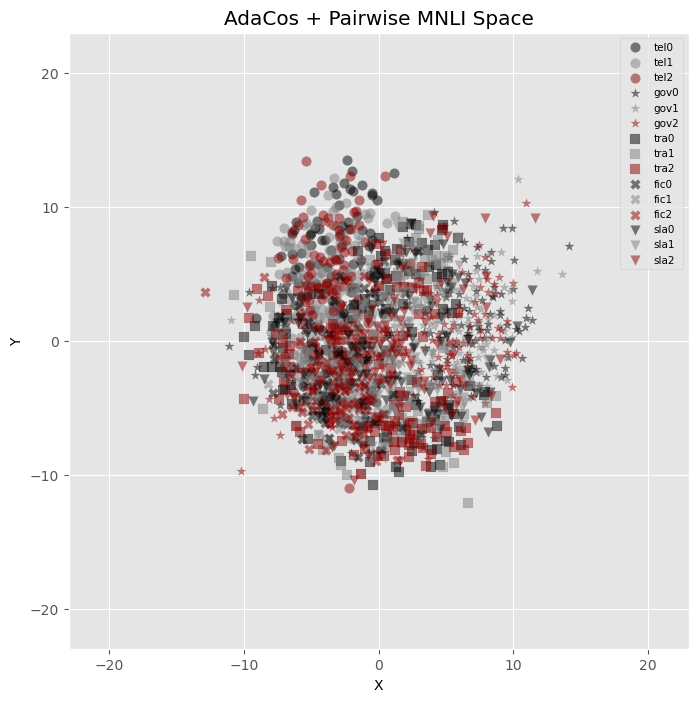

In [17]:
# plot the data
plt.style.use('ggplot')
fig, ax1 = plt.subplots(1, 1, figsize=(8,8))
colorlist = ["black","grey","darkred"]
markers = ["o","*","s","X","v"]

# prepare dataframe with data
plot_df = pd.DataFrame(zip(list(X[:, 0]), list(X[:, 1]), [genre[:3]+str(label) for genre,label in zip(genres,labs)]), columns=["X","Y","Genre"])
l_unq = plot_df['Genre'].unique()

for i, genre in enumerate(l_unq):
    x = plot_df[(plot_df.Genre==genre)].X
    y = plot_df[(plot_df.Genre==genre)].Y
    # color depends on polarity
    # marker depends on genre
    ax1.scatter(x, y, marker=markers[i//3], label=genre, s=50, linewidth=0.1, c=colorlist[int(genre[-1])], alpha=0.5)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(-23, 23)
ax1.set_ylim(-23, 23)
ax1.legend(loc=1, prop={'size': 7.5})
ax1.set_title("AdaCos + Pairwise MNLI Space")

plt.show()